## Первичный анализ датасета

#### Все нужные import

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

#### Инициализация датасета

In [33]:
df = pd.read_csv("../datasets/yu_dataset.csv")

#### Круговая диаграмма

             Категория  Количество
0                  нет        2371
1              студент          45
2  информационный сайт          29
3         видеохостинг          17
4                Всего        2462


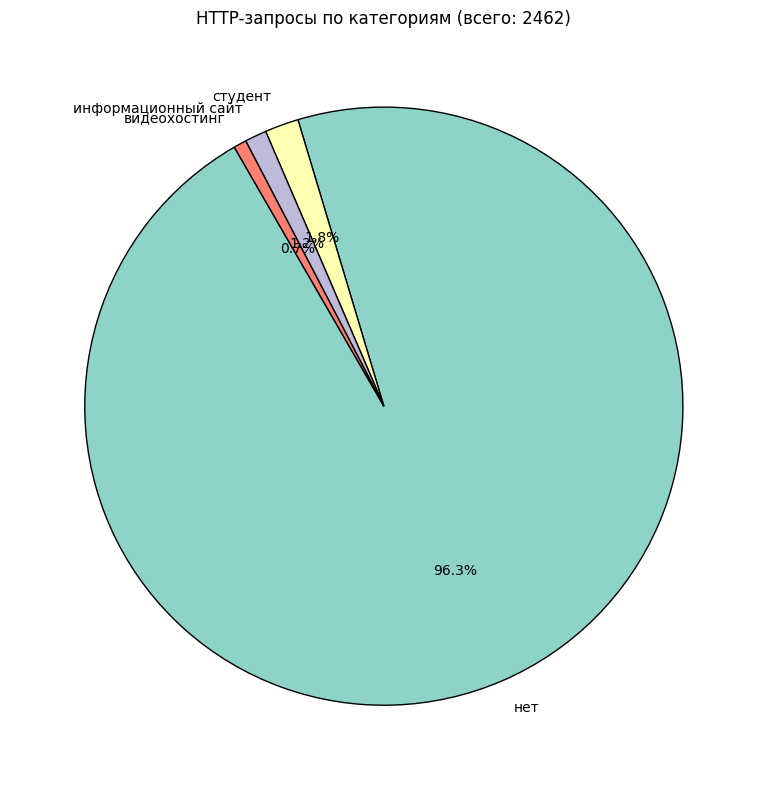

In [34]:
if 'http_url_categories' not in df.columns:
    raise RuntimeError("Колонка 'http_url_categories' не обнаружена в DataFrame.")

cat_stats = df['http_url_categories'].value_counts()
total_entries = len(df['http_url_categories'].dropna())

stats_df = cat_stats.reset_index()
stats_df.columns = ['Категория', 'Количество']
stats_df.loc[len(stats_df.index)] = ['Всего', total_entries]
print(stats_df)

fig, chart = plt.subplots(figsize=(8, 8))
chart.pie(
    cat_stats.values,
    labels=cat_stats.index,
    autopct='%1.1f%%',
    startangle=120,
    colors=plt.get_cmap('Set3').colors,
    wedgeprops={'edgecolor': 'black'}
)

chart.set_title(f"HTTP-запросы по категориям (всего: {total_entries})")
plt.tight_layout()
plt.savefig("../img/pie_chart_http_categories.png", dpi=300)
plt.show()


## Классификация данных

#### Создание столбцов Label_y Label_x

In [35]:
Label_y = df['http_url_categories']
Label_x = df.drop(columns=['time_window_start', 'http_url_categories'])

print("Первые строки целевого столбца:")
print(Label_y.head())

print("\nПервые строки признаков:")
pd.DataFrame(Label_x, columns=Label_x.columns).head()

Первые строки целевого столбца:
0    нет
1    нет
2    нет
3    нет
4    нет
Name: http_url_categories, dtype: object

Первые строки признаков:


,tcp_packet_count,udp_packet_count,http_packet_count,tcp_sessions_count,udp_sessions_count,tcp_src_ports_count,udp_src_ports_count,tcp_dst_ports_count,udp_dst_ports_count,avg_pkt_length,avg_tcp_pkt_length,avg_udp_pkt_length,unique_ip_count,http_url_count,avg_http_url_length
0,0,0,0,0,0,0,0,0,0,62,0,0,0,0,0
1,0,22,0,0,1,0,1,0,1,392,0,482,2,0,0
2,2,0,0,2,0,2,0,2,0,61,60,0,2,0,0
3,0,0,0,0,0,0,0,0,0,62,0,0,0,0,0
4,16,4,0,4,0,3,3,3,3,306,432,167,2,4,26


#### Обработка данных для классификаторов

In [36]:
le = LabelEncoder()
Label_y_encoded = le.fit_transform(Label_y)

scaler = StandardScaler()
Label_x_scaled = scaler.fit_transform(Label_x)

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\nКодировка категорий (Label_y):")
print(label_mapping)

print("\nПервые строки масштабированных признаков:")
pd.DataFrame(Label_x_scaled, columns=Label_x.columns).head()


Кодировка категорий (Label_y):
{'видеохостинг': np.int64(0), 'информационный сайт': np.int64(1), 'нет': np.int64(2), 'студент': np.int64(3)}

Первые строки масштабированных признаков:


,tcp_packet_count,udp_packet_count,http_packet_count,tcp_sessions_count,udp_sessions_count,tcp_src_ports_count,udp_src_ports_count,tcp_dst_ports_count,udp_dst_ports_count,avg_pkt_length,avg_tcp_pkt_length,avg_udp_pkt_length,unique_ip_count,http_url_count,avg_http_url_length
0,-0.303456,-0.156971,-0.080198,-0.758413,-0.331152,-0.925525,-0.413306,-0.809027,-0.409475,-0.990174,-1.113858,-0.586117,-1.053652,-0.255921,-0.356075
1,-0.303456,-0.093380,-0.080198,-0.758413,-0.170407,-0.925525,-0.121992,-0.809027,-0.113315,-0.059374,-1.113858,1.160077,-0.670109,-0.255921,-0.356075
2,-0.301997,-0.156971,-0.080198,-0.584476,-0.331152,-0.608893,-0.413306,-0.471915,-0.409475,-0.992994,-0.958679,-0.586117,-0.670109,-0.255921,-0.356075
3,-0.303456,-0.156971,-0.080198,-0.758413,-0.331152,-0.925525,-0.413306,-0.809027,-0.409475,-0.990174,-1.113858,-0.586117,-1.053652,-0.255921,-0.356075
4,-0.291784,-0.145409,-0.080198,-0.410539,-0.331152,-0.450577,0.460635,-0.303360,0.479004,-0.301946,0.003429,0.018892,-0.670109,0.603667,3.145161


#### Разделение на обучающую и тестовую выборки

Пропорция: Вариант 29 (4:10)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    Label_x_scaled,
    Label_y_encoded,
    test_size=4/7,
    random_state=42, 
    stratify=Label_y_encoded 
)

print("\nРазмер обучающей выборки:", x_train.shape[0])
print("Размер тестовой выборки:", x_test.shape[0])


Размер обучающей выборки: 1055
Размер тестовой выборки: 1407


#### Обучение классификаторов

In [38]:
results = {}

for depth in [2, 5]:
    gbc = GradientBoostingClassifier(max_depth=depth, random_state=42)
    gbc.fit(x_train, y_train)
    y_pred = gbc.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    results[f"GradientBoosting (depth={depth})"] = acc

for depth in [2, 5]:
    rf = RandomForestClassifier(max_depth=depth, random_state=42)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    results[f"RandomForest (depth={depth})"] = acc

print("\nРезультаты классификации:")
for model_name, acc in results.items():
    print(f"{model_name}: точность = {acc:.4f}")



Результаты классификации:
GradientBoosting (depth=2): точность = 0.9680
GradientBoosting (depth=5): точность = 0.9694
RandomForest (depth=2): точность = 0.9630
RandomForest (depth=5): точность = 0.9730


#### Получение метрик оценок эффективности классификации

In [41]:
models = []
metrics = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": [],
    "ROC-AUC": []
}

for depth in [2, 5]:
    for model_type, Model in [
        ("GradientBoosting", GradientBoostingClassifier),
        ("RandomForest", RandomForestClassifier)
    ]:
        clf = Model(max_depth=depth, random_state=42)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)

        model_name = f"{model_type}_depth={depth}"
        models.append(model_name)

        metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
        metrics["Precision"].append(precision_score(y_test, y_pred, average="weighted", zero_division=0))
        metrics["Recall"].append(recall_score(y_test, y_pred, average="weighted"))
        metrics["F1 Score"].append(f1_score(y_test, y_pred, average="weighted"))

        try:
            y_proba = clf.predict_proba(x_test)
            roc_auc = roc_auc_score(y_test, y_proba, multi_class="ovr", average="weighted")
        except:
            roc_auc = float('nan')
        metrics["ROC-AUC"].append(roc_auc)

# Вывод результатов
print("Список моделей:")
print(models)
print("\nМетрики по моделям:")

import pandas as pd
df_metrics = pd.DataFrame(metrics, index=models)
print(df_metrics)


Список моделей:
['GradientBoosting_depth=2', 'RandomForest_depth=2', 'GradientBoosting_depth=5', 'RandomForest_depth=5']

Метрики по моделям:
                          Accuracy  Precision    Recall  F1 Score   ROC-AUC
GradientBoosting_depth=2  0.968017   0.965760  0.968017  0.966382  0.972749
RandomForest_depth=2      0.963042   0.927450  0.963042  0.944911  0.967852
GradientBoosting_depth=5  0.969439   0.969032  0.969439  0.968748  0.974059
RandomForest_depth=5      0.972992   0.956008  0.972992  0.964354  0.975292


### Вывод

Все модели показали высокое качество классификации с точностью около 96–97%. Лучшие результаты по точности и F1-мере продемонстрировал случайный лес с глубиной 5, что свидетельствует о положительном влиянии увеличения глубины на качество модели. Градиентный бустинг с такой же глубиной также показал близкие показатели, подтверждая свою эффективность. Несмотря на то, что точность у случайного леса была немного выше, у градиентного бустинга наблюдался более высокий показатель precision, что говорит о лучшей сбалансированности между точностью и полнотой. Метрика ROC-AUC для всех моделей превышает 0.96, что свидетельствует о высокой способности моделей правильно различать классы. В целом, увеличение глубины дерева с 2 до 5 приводит к небольшому, но стабильному улучшению всех метрик, поэтому при наличии достаточных вычислительных ресурсов предпочтительно использовать более глубокие модели для достижения максимального качества.

#### Визуализация

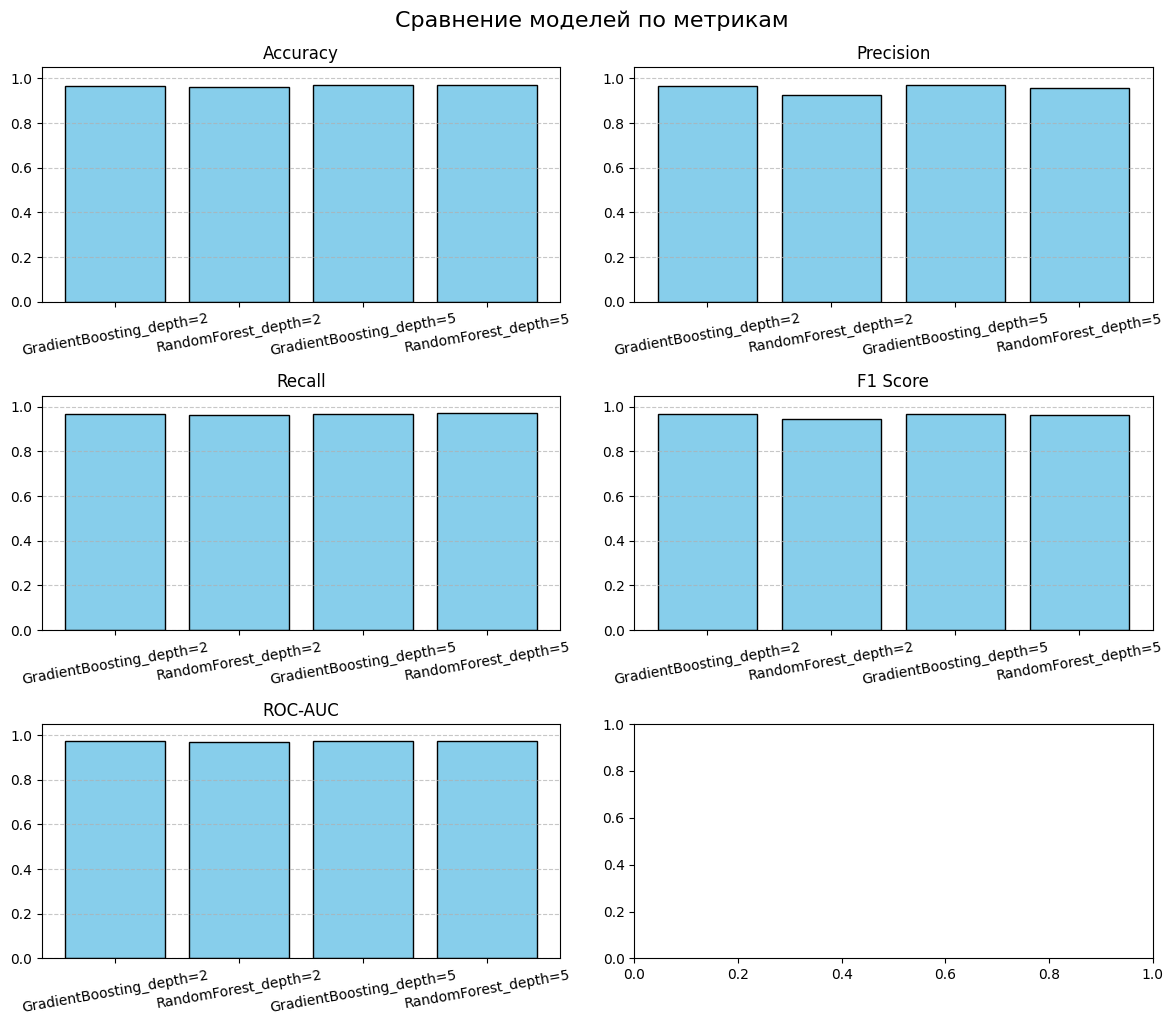

In [40]:
x = np.arange(len(models))

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

for i, (metric_name, values) in enumerate(metrics.items()):
    axs[i].bar(x, values, color='skyblue', edgecolor='black')
    axs[i].set_title(metric_name)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(models, rotation=10)
    axs[i].set_ylim(0, 1.05)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.suptitle("Сравнение моделей по метрикам", fontsize=16, y=1.02)
plt.savefig("../img/classifier_comparison.png")
plt.show()
